# TensorFlow 2.0

In [1]:
import os
from glob import glob
from datetime import datetime

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import datasets 

import matplotlib.pyplot as plt

%load_ext tensorboard
%matplotlib inline

## Hyperparameter Tunning

In [2]:
num_epochs = 5
batch_size = 32

learning_rate = 0.001

dropout_rate = 0.5

input_shape = (32, 32, 3)
num_classes = 10

## Build Model

In [3]:
inputs = layers.Input(input_shape)

net = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

In [4]:
# Model is the full model w/o custom layers
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),  # Optimization
              loss='sparse_categorical_crossentropy',  # Loss Function 
              metrics=['accuracy'])  # Metrics / Accuracy

# Data Preprocess

In [5]:
train_paths = glob(r'C:\Users\LG\Deep_Learning_Study\Tensorflow\dataset\cifar\train\*.png')[:100]
test_paths = glob(r'C:\Users\LG\Deep_Learning_Study\Tensorflow\dataset\cifar\test\*.png')[:100]

In [6]:
def get_class_name(path):
    return path.split('_')[-1].replace('.png', '')

In [7]:
train_labels = [get_class_name(path) for path in train_paths]
class_names = np.unique(train_labels)

In [8]:
def get_label(path):
    fname = tf.strings.split(path, '_')[-1]
    lbl_name = tf.strings.regex_replace(fname, '.png', '')
    onehot = tf.cast(lbl_name == class_names, tf.uint8)
    return tf.argmax(onehot)  # 이번에는 onehot이 아닌 label 번호로

In [9]:
def load_image_label(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    image = tf.cast(image, tf.float32) / 255.  # rescale
    
    label = get_label(path)
    return image, label

In [10]:
def image_preprocess(image, label):
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    return image, label

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(image_preprocess, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths))
train_dataset = train_dataset.repeat()

In [13]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.repeat()

## Training

In [14]:
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(test_paths) // batch_size

model.fit_generator(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    epochs=num_epochs
)

Epoch 1/5
3/3 [==============================] - 1s 426ms/step - loss: 2.3918 - accuracy: 0.0588 - val_loss: 2.3105 - val_accuracy: 0.1979
Epoch 2/5
3/3 [==============================] - 1s 328ms/step - loss: 2.2166 - accuracy: 0.0882 - val_loss: 2.3271 - val_accuracy: 0.0729
Epoch 3/5
3/3 [==============================] - 1s 385ms/step - loss: 2.3875 - accuracy: 0.0417 - val_loss: 2.3353 - val_accuracy: 0.0729
Epoch 4/5
3/3 [==============================] - 1s 303ms/step - loss: 2.1871 - accuracy: 0.1176 - val_loss: 2.3545 - val_accuracy: 0.0729
Epoch 5/5
3/3 [==============================] - 1s 366ms/step - loss: 2.3356 - accuracy: 0.0729 - val_loss: 2.3190 - val_accuracy: 0.1042


# Predict

### 이미지를 Load 직접 load해서 넣는 방법

In [16]:
path = test_paths[0]
path

'C:\\Users\\LG\\Deep_Learning_Study\\Tensorflow\\dataset\\cifar\\test\\0_cat.png'

In [23]:
gfile = tf.io.read_file(path)
image = tf.io.decode_image(gfile, dtype=tf.float32)
image.shape

TensorShape([32, 32, 3])

In [24]:
image = image[tf.newaxis, ...]
image.shape

TensorShape([1, 32, 32, 3])

In [25]:
pred = model.predict(image)

In [26]:
pred.shape

(1, 10)

In [32]:
print(pred)
print(tf.argmax(pred, axis=1))

[[0.09883995 0.09215767 0.11145175 0.09073673 0.11013214 0.07072993
  0.10138362 0.10369484 0.12613119 0.09474217]]
tf.Tensor([8], shape=(1,), dtype=int64)


### generator에서 데이터를 가져오는 방법

In [33]:
test_image, test_label = next(iter(test_dataset))

In [34]:
test_image.shape

TensorShape([32, 32, 32, 3])

In [49]:
pred = model.predict(test_image)
pred.shape

(32, 10)

In [50]:
pred[0]

array([0.09883996, 0.09215767, 0.11145175, 0.09073673, 0.11013214,
       0.07072993, 0.10138362, 0.10369485, 0.12613119, 0.09474217],
      dtype=float32)

In [51]:
tf.argmax(pred)

<tf.Tensor: id=6700, shape=(10,), dtype=int64, numpy=array([ 5, 19, 21, 19, 15, 19, 29, 26, 21, 29], dtype=int64)>

### generator에 넣는 방법

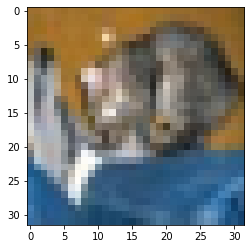

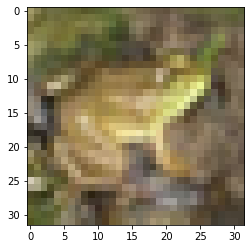

In [56]:
for image, label in test_dataset.take(2):
    plt.imshow(image[0])
    plt.show()

In [52]:
pred = model.predict_generator(test_dataset.take(1))
pred.shape

(32, 10)

In [57]:
tf.argmax(pred)

<tf.Tensor: id=6793, shape=(10,), dtype=int64, numpy=array([ 5, 19, 21, 19, 15, 19, 29, 26, 21, 29], dtype=int64)>

In [ ]:
image, label = next(iter(test_dataset.take(!
                                          )))

### Evaluate

In [58]:
evals = model.evaluate(image, label)

32/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 6ms/sample - loss: 2.3240 -

In [59]:
evals

[2.324016571044922, 0.03125]